In [ ]:
# !unzip /network/tmp1/cosnegau/dataset_cosnegau.zip -d /network/tmp1/cosnegau/
# !ls /network/tmp1/cosnegau/

In [ ]:
# !pip3 install --no-cache-dir tensorflow-gpu

In [ ]:
# !pip install scipy
# !pip install scikit-image
# !pip install visvis
# !pip install opencv-python

**Change the path to the temporary folder it is stored**

In [ ]:
# import string
# path = "/network/tmp1/cosnegau/Dataset/"
# list_sub_path=["both_road_test", "both_road_train", "off_road_test","off_road_train","on_road_test","on_road_train"]

# for sub_path in list_sub_path:
#     full_path = path+sub_path+".txt"
#     s = open(full_path).read()
#     s = s.replace('..', '/network/tmp1/cosnegau')
#     f = open(full_path, 'w')
#     f.write(s)
#     f.close()

**Actual Code**

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import TensorflowUtils as utils
import datetime
from six.moves import xrange
import glob
from skimage import io, transform, color
import glob
import os
import time
import imageio

FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_integer("batch_size", "1", "batch size for training")
tf.flags.DEFINE_string("logs_dir", "/network/tmp1/cosnegau/models/", "path to logs directory")
tf.flags.DEFINE_string("data_dir", "/network/tmp1/cosnegau/Dataset/", "path to dataset")
tf.flags.DEFINE_string("output_dir", "/network/tmp1/cosnegau/results/", "path of output")
tf.flags.DEFINE_float("learning_rate", "1e-6", "Learning rate for Adam Optimizer")
tf.flags.DEFINE_bool('debug', "False", "Debug mode: True/ False")
tf.flags.DEFINE_string('mode', "visualize", "Mode train/ test/ visualize")

MAX_ITERATION = int(1e5 + 1)
NUM_OF_CLASSESS = 2
batch_offset = 0
IMAGE_SIZE_HEIGHT = 360
IMAGE_SIZE_WIDTH = 640

In [2]:
def load_training_dataset_path():
    p = np.genfromtxt(FLAGS.data_dir+'on_road_train.txt',dtype='str')
    return p

def load_data(p, step):
    imgs=[]
    gt_imgs=[]
    gt_imgs2=[]
    for i in range(p.shape[0]):
        fp = p[i,0]
        fp_gt = p[i,1]
        #print("Loading images: %s \t %s"%(fp, fp_gt))

        img = io.imread(fp)
        img = img[:,0:1280,:]
        img = transform.resize(img, (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
        imgs.append(img)

        gt_img = io.imread(fp_gt)
        gt_img = transform.resize(gt_img, (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
    for r in range(gt_img.shape[0]):
        for c in range(gt_img.shape[1]):
            if gt_img[r,c] == 1:
                gt_img[r,c] = 1
    else:
        gt_img[r,c] = 0
        
    gt_imgs.append(gt_img)

    gt_img2 = io.imread(fp_gt)
    gt_img2 = transform.resize(gt_img2, (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
    for r in range(gt_img2.shape[0]):
        for c in range(gt_img2.shape[1]):
            if gt_img2[r,c] == 1:
                gt_img2[r,c] = 0
            else:
                gt_img2[r,c] = 1
    gt_imgs2.append(gt_img2)

    return np.asarray(imgs,np.float32), np.asarray(gt_imgs,np.int32), np.asarray(gt_imgs2, np.int32)

def load_test_data(p):
    imgs=[]
    im = p
    img = io.imread(im)
    #print('img.shape', img.shape)
    img = img[:,0:1280,:]
    img = transform.resize(img, (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
    imgs.append(img)
    return np.asarray(imgs, np.float32)

def inference(image, keep_prob):

    with tf.variable_scope("seg_inference"):
        W1_1 = utils.weight_variable([3, 3, 3, 64], name="W1_1")
        b1_1 = utils.bias_variable([64], name="b1_1")
        conv1_1 = utils.conv2d_basic(image, W1_1, b1_1)
        relu1_1 = tf.nn.relu(conv1_1, name="relu1_1")

        W1_2 = utils.weight_variable([3, 3, 64, 64], name="W1_2")
        b1_2 = utils.bias_variable([64], name="b1_2")
        conv1_2 = utils.conv2d_basic(relu1_1, W1_2, b1_2)
        relu1_2 = tf.nn.relu(conv1_2, name="relu1_2")

        ra_1, ra_1_small = utils.RA_unit(relu1_2, relu1_2.shape[1].value, relu1_2.shape[2].value, 16)
        W_s1 = utils.weight_variable([3, 3, 64*(1+16), 64], name="W_s1")
        b_s1 = utils.bias_variable([64], name="b_s1")
        conv_s1 = utils.conv2d_basic(ra_1, W_s1, b_s1)
        relu_s1 = tf.nn.relu(conv_s1, name="relu_s1")

        pool1 = utils.max_pool_2x2(relu_s1)

        W2_1 = utils.weight_variable([3, 3, 64, 128], name="W2_1")
        b2_1 = utils.bias_variable([128], name="b2_1")
        conv2_1 = utils.conv2d_basic(pool1, W2_1, b2_1)
        relu2_1 = tf.nn.relu(conv2_1, name="relu2_1")

        W2_2 = utils.weight_variable([3, 3, 128, 128], name="W2_2")
        b2_2 = utils.bias_variable([128], name="b2_2")
        conv2_2 = utils.conv2d_basic(relu2_1, W2_2, b2_2)
        relu2_2 = tf.nn.relu(conv2_2, name="relu2_2")

        ra_2, ra_2_small = utils.RA_unit(relu2_2, relu2_2.shape[1].value, relu2_2.shape[2].value, 16)
        W_s2 = utils.weight_variable([3, 3, 128*(1+16), 128], name="W_s2")
        b_s2 = utils.bias_variable([128], name="b_s2")
        conv_s2 = utils.conv2d_basic(ra_2, W_s2, b_s2)
        relu_s2 = tf.nn.relu(conv_s2, name="relu_s2")

        pool2 = utils.max_pool_2x2(relu_s2)

        W3_1 = utils.weight_variable([3, 3, 128, 256], name="W3_1")
        b3_1 = utils.bias_variable([256], name="b3_1")
        conv3_1 = utils.conv2d_basic(pool2, W3_1, b3_1)
        relu3_1 = tf.nn.relu(conv3_1, name="relu3_1")

        W3_2 = utils.weight_variable([3, 3, 256, 256], name="W3_2")
        b3_2 = utils.bias_variable([256], name="b3_2")
        conv3_2 = utils.conv2d_basic(relu3_1, W3_2, b3_2)
        relu3_2 = tf.nn.relu(conv3_2, name="relu3_2")

        W3_3 = utils.weight_variable([3, 3, 256, 256], name="W3_3")
        b3_3 = utils.bias_variable([256], name="b3_3")
        conv3_3 = utils.conv2d_basic(relu3_2, W3_3, b3_3)
        relu3_3 = tf.nn.relu(conv3_3, name="relu3_3")

        ra_3, ra_3_small = utils.RA_unit(relu3_3, relu3_3.shape[1].value, relu3_3.shape[2].value, 16)
        W_s3 = utils.weight_variable([3, 3, 256*(1+16), 256], name="W_s3")
        b_s3 = utils.bias_variable([256], name="b_s3")
        conv_s3 = utils.conv2d_basic(ra_3, W_s3, b_s3)
        relu_s3 = tf.nn.relu(conv_s3, name="relu_s3")

        pool3 = utils.max_pool_2x2(relu_s3)

        W4_1 = utils.weight_variable([3, 3, 256, 512], name="W4_1")
        b4_1 = utils.bias_variable([512], name="b4_1")
        conv4_1 = utils.conv2d_basic(pool3, W4_1, b4_1)
        relu4_1 = tf.nn.relu(conv4_1, name="relu4_1")

        W4_2 = utils.weight_variable([3, 3, 512, 512], name="W4_2")
        b4_2 = utils.bias_variable([512], name="b4_2")
        conv4_2 = utils.conv2d_basic(relu4_1, W4_2, b4_2)
        relu4_2 = tf.nn.relu(conv4_2, name="relu4_2")

        W4_3 = utils.weight_variable([3, 3, 512, 512], name="W4_3")
        b4_3 = utils.bias_variable([512], name="b4_3")
        conv4_3 = utils.conv2d_basic(relu4_2, W4_3, b4_3)
        relu4_3 = tf.nn.relu(conv4_3, name="relu4_3")

        ra_4, ra_4_small = utils.RA_unit(relu4_3, relu4_3.shape[1].value, relu4_3.shape[2].value, 16)
        W_s4 = utils.weight_variable([3, 3, 512*(1+16), 512], name="W_s4")
        b_s4 = utils.bias_variable([512], name="b_s4")
        conv_s4 = utils.conv2d_basic(ra_4, W_s4, b_s4)
        relu_s4 = tf.nn.relu(conv_s4, name="relu_s4")

        pool4 = utils.max_pool_2x2(relu_s4)

        W5_1 = utils.weight_variable([3, 3, 512, 512], name="W5_1")
        b5_1 = utils.bias_variable([512], name="b5_1")
        conv5_1 = utils.conv2d_basic(pool4, W5_1, b5_1)
        relu5_1 = tf.nn.relu(conv5_1, name="relu5_1")

        W5_2 = utils.weight_variable([3, 3, 512, 512], name="W5_2")
        b5_2 = utils.bias_variable([512], name="b5_2")
        conv5_2 = utils.conv2d_basic(relu5_1, W5_2, b5_2)
        relu5_2 = tf.nn.relu(conv5_2, name="relu5_2")

        W5_3 = utils.weight_variable([3, 3, 512, 512], name="W5_3")
        b5_3 = utils.bias_variable([512], name="b5_3")
        conv5_3 = utils.conv2d_basic(relu5_2, W5_3, b5_3)
        relu5_3 = tf.nn.relu(conv5_3, name="relu5_3")

        ra_5, ra_5_small = utils.RA_unit(relu5_3, relu5_3.shape[1].value, relu5_3.shape[2].value, 8)
        W_s5 = utils.weight_variable([3, 3, 512*(1+8), 512], name="W_s5")
        b_s5 = utils.bias_variable([512], name="b_s5")
        conv_s5 = utils.conv2d_basic(ra_5, W_s5, b_s5)
        relu_s5 = tf.nn.relu(conv_s5, name="relu_s5")

        pool5 = utils.max_pool_2x2(relu_s5)

        W6 = utils.weight_variable([7, 7, pool4.shape[3].value, 4096], name="W6")
        b6 = utils.bias_variable([4096], name="b6")
        conv6 = utils.conv2d_basic(pool4, W6, b6)
        relu6 = tf.nn.relu(conv6, name="relu6")

        relu_dropout6 = tf.nn.dropout(relu6, keep_prob=keep_prob)

        W7 = utils.weight_variable([1, 1, 4096, 4096], name="W7")
        b7 = utils.bias_variable([4096], name="b7")
        conv7 = utils.conv2d_basic(relu_dropout6, W7, b7)
        relu7 = tf.nn.relu(conv7, name="relu7")

        relu_dropout7 = tf.nn.dropout(relu7, keep_prob=keep_prob)

        W8 = utils.weight_variable([1, 1, 4096, NUM_OF_CLASSESS], name="W8")            #in our case num_of_classess = 2 : road, non-road
        b8 = utils.bias_variable([NUM_OF_CLASSESS], name="b8")
        conv8 = utils.conv2d_basic(relu_dropout7, W8, b8)

        # now to upscale to actual image size
        deconv_shape1 = pool3.get_shape()
        W_t1 = utils.weight_variable([4, 4, deconv_shape1[3].value, NUM_OF_CLASSESS], name="W_t1")
        b_t1 = utils.bias_variable([deconv_shape1[3].value], name="b_t1")
        conv_t1 = utils.conv2d_transpose_strided(conv8, W_t1, b_t1, output_shape=tf.shape(pool3))
        fuse_1 = tf.add(conv_t1, pool3, name="fuse_1")

        deconv_shape2 = pool2.get_shape()
        W_t2 = utils.weight_variable([4, 4, deconv_shape2[3].value, deconv_shape1[3].value], name="W_t2")
        b_t2 = utils.bias_variable([deconv_shape2[3].value], name="b_t2")
        conv_t2 = utils.conv2d_transpose_strided(fuse_1, W_t2, b_t2, output_shape=tf.shape(pool2))
        fuse_2 = tf.add(conv_t2, pool2, name="fuse_2")
        #print("fuse_2 shape:")
        #print(fuse_2.shape)

        shape = tf.shape(image)
        deconv_shape3 = tf.stack([shape[0], shape[1], shape[2], NUM_OF_CLASSESS])
        W_t3 = utils.weight_variable([16, 16, NUM_OF_CLASSESS, fuse_2.shape[3].value], name="W_t3")
        b_t3 = utils.bias_variable([NUM_OF_CLASSESS], name="b_t3")
        conv_t3 = utils.conv2d_transpose_strided(fuse_2, W_t3, b_t3, output_shape=deconv_shape3, stride=4, stride_y=4)

        annotation_pred = tf.argmax(conv_t3, dimension=3, name="prediction")

    return annotation_pred, conv_t3                # conv_t3 is the final result

def train(loss_val, var_list):
    optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
    grads = optimizer.compute_gradients(loss_val, var_list=var_list)
    return optimizer.apply_gradients(grads)

def next_batch(batch_size, step):
    global batch_offset
    global p
    start = batch_offset
    batch_offset += batch_size
    if batch_offset > p.shape[0]:
        #         print("Shuffle data")
        # Shuffle the data
        perm = np.arange(p.shape[0])
        np.random.shuffle(perm)
        p = p[perm]
        # Start next epoch
        start = 0
        batch_offset = batch_size
    end = batch_offset
    #print("train_img start %d end %d"%(start, end))
    return p[start:end]
def color_img(path):
    return(imageio.imread(path).shape[2]==3)

def main(argv=None):
    keep_probability = tf.placeholder(tf.float32, name="keep_probabilty")
    image = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH, 3], name="input_image")
    annotation = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH, 2], name="annotation")
    pred_annotation, logits = inference(image, keep_probability)            # build the FCN graph

    prob = tf.nn.softmax(logits)

    logits_ = tf.reshape(logits, [1, IMAGE_SIZE_HEIGHT*IMAGE_SIZE_WIDTH, 2])
    annotation_ = tf.reshape(annotation, [1, IMAGE_SIZE_HEIGHT*IMAGE_SIZE_WIDTH, 2])
    loss = utils.focal_loss(logits_, annotation_)

    trainable_var = tf.trainable_variables()
    train_op = train(loss, trainable_var)

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True

    sess = tf.Session(config = config)

    print("Setting up Saver...")
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(FLAGS.logs_dir)
    if ckpt and ckpt.model_checkpoint_path and FLAGS.mode=="visualize":
        saver.restore(sess, ckpt.model_checkpoint_path)
        print("Model restored...")

    if FLAGS.mode == "train":
        print("Loading data")
        global p;
        p = load_training_dataset_path()
        #train_imgs, gt_imgs = load_data(FLAGS.data_dir)
        #gt_imgs = np.expand_dims(gt_imgs, axis=3)
        print("Start Training...")
        for itr in xrange(MAX_ITERATION):
            print('Step: %d'%(itr))
            p1 = next_batch(FLAGS.batch_size, itr)
            # print("p1:\n",p1)
            x_train, y_train, y_train2 = load_data(p1, itr)
            y_train = np.expand_dims(y_train, axis=3)
            y_train2 = np.expand_dims(y_train2, axis=3)
            label_in = np.concatenate((y_train2, y_train), axis=3)
            #x_train, y_train = next_batch(train_imgs, gt_imgs, FLAGS.batch_size)    
            feed_dict = {image: x_train, annotation: label_in, keep_probability: 0.85}
            # print("train feed_dict done!")
            start_time = time.time()
            sess.run(train_op, feed_dict = feed_dict)
            dur = time.time() - start_time
            print("duration : %f"% dur)
            if itr % 1 == 0:
                train_loss = sess.run(loss, feed_dict = feed_dict)
                print('KITTI Step: %d, Train_loss:%g'%(itr, train_loss))
            #if itr % 100 == 0:
                #    summary = sess.run(merged, feed_dict = feed_dict)
                #    summary_writer.add_summary(summary, itr)
            if itr % 5000 == 0:
                print('Save Net Model...')
                saver.save(sess, FLAGS.logs_dir + "model.ckpt", itr)
            if itr % 5000 == 0 and itr >= 20000:
                FLAGS.learning_rate = FLAGS.learning_rate / 2
    elif FLAGS.mode == "visualize":
        p = np.genfromtxt(FLAGS.data_dir+'on_road_test.txt', dtype='str')
        for idx in range(0,p.shape[0]):
#             p = p.reshape(-1,1)
            if color_img(p[idx,0]):
                test_images1 = load_test_data(p[idx,0])
                img_name= p[idx,0].split('/')[-1].split('_')[1][:-4]
#                 img_name= p[idx,0].split('/')[-1][:-4]#.split('_')[1][:-4]

                print(img_name)
                start_time = time.time()
                likelyhood, pred = sess.run([prob, pred_annotation], feed_dict={image:test_images1, keep_probability: 1.0})
                dur = time.time() - start_time
                print("dur = ",dur)
                print(pred.shape)
                for itr in range(pred.shape[0]):
                    utils.save_image(pred[itr].astype(np.float32), FLAGS.output_dir, name=img_name)
                    print("Saved image :",img_name)


In [3]:
tf.app.run()

Instructions for updating:
Colocations handled automatically by placer.
h and n : 360 16
h and n : 180 16
h and n : 90 16
h and n : 45 16
h and n : 23 8
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use the `axis` argument instead
Setting up Saver...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /network/tmp1/cosnegau/models/model.ckpt-55000
Model restored...
000000301


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  4.299794435501099
(1, 360, 640)
Saved image : 000000301
000000911


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4130723476409912
(1, 360, 640)
Saved image : 000000911
000000221


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4107658863067627
(1, 360, 640)
Saved image : 000000221
000005181


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4128153324127197
(1, 360, 640)
Saved image : 000005181
000004001


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4120442867279053
(1, 360, 640)
Saved image : 000004001
000003271


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4093742370605469
(1, 360, 640)
Saved image : 000003271
000002101


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4118056297302246
(1, 360, 640)
Saved image : 000002101
000004981


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41390037536621094
(1, 360, 640)
Saved image : 000004981
000000391


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41185665130615234
(1, 360, 640)
Saved image : 000000391
000005101


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4143521785736084
(1, 360, 640)
Saved image : 000005101
000000781


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4120922088623047
(1, 360, 640)
Saved image : 000000781
000000281


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4092681407928467
(1, 360, 640)
Saved image : 000000281
000000771


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4102296829223633
(1, 360, 640)
Saved image : 000000771
000000151


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40823960304260254
(1, 360, 640)
Saved image : 000000151
000000871


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41197943687438965
(1, 360, 640)
Saved image : 000000871
000002531


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.411557674407959
(1, 360, 640)
Saved image : 000002531
000002251


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40800976753234863
(1, 360, 640)
Saved image : 000002251
000000101


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4103877544403076
(1, 360, 640)
Saved image : 000000101
000005131


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4120638370513916
(1, 360, 640)
Saved image : 000005131
000005331


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4117739200592041
(1, 360, 640)
Saved image : 000005331
000002201


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4134998321533203
(1, 360, 640)
Saved image : 000002201
000001271


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41208481788635254
(1, 360, 640)
Saved image : 000001271
000000751


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4095876216888428
(1, 360, 640)
Saved image : 000000751
000000471


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41220688819885254
(1, 360, 640)
Saved image : 000000471
000000491


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41402125358581543
(1, 360, 640)
Saved image : 000000491
000000621


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40928220748901367
(1, 360, 640)
Saved image : 000000621
000000941


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41121363639831543
(1, 360, 640)
Saved image : 000000941
000000511


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4078488349914551
(1, 360, 640)
Saved image : 000000511
000003421


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4119424819946289
(1, 360, 640)
Saved image : 000003421
000003861


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41332507133483887
(1, 360, 640)
Saved image : 000003861
000000381


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4125545024871826
(1, 360, 640)
Saved image : 000000381
000003891


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4109480381011963
(1, 360, 640)
Saved image : 000003891
000004591


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41225719451904297
(1, 360, 640)
Saved image : 000004591
000005031


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40775394439697266
(1, 360, 640)
Saved image : 000005031
000003791


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4088170528411865
(1, 360, 640)
Saved image : 000003791
000001121


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40987443923950195
(1, 360, 640)
Saved image : 000001121
000000251


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4109632968902588
(1, 360, 640)
Saved image : 000000251
000000181


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40949416160583496
(1, 360, 640)
Saved image : 000000181
000005191


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40770435333251953
(1, 360, 640)
Saved image : 000005191
000005231


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4074242115020752
(1, 360, 640)
Saved image : 000005231
000000191


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.413175106048584
(1, 360, 640)
Saved image : 000000191
000004461


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4057159423828125
(1, 360, 640)
Saved image : 000004461
000000591


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4065718650817871
(1, 360, 640)
Saved image : 000000591
000003711


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41411304473876953
(1, 360, 640)
Saved image : 000003711
000001151


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4169440269470215
(1, 360, 640)
Saved image : 000001151
000001261


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41442394256591797
(1, 360, 640)
Saved image : 000001261
000003991


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41063880920410156
(1, 360, 640)
Saved image : 000003991
000001431


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40875840187072754
(1, 360, 640)
Saved image : 000001431
000000531


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4133567810058594
(1, 360, 640)
Saved image : 000000531
000005001


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41315555572509766
(1, 360, 640)
Saved image : 000005001
000000421


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41243815422058105
(1, 360, 640)
Saved image : 000000421
000003811


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4118685722351074
(1, 360, 640)
Saved image : 000003811
000003981


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41707491874694824
(1, 360, 640)
Saved image : 000003981
000004051


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4131584167480469
(1, 360, 640)
Saved image : 000004051
000000631


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4096832275390625
(1, 360, 640)
Saved image : 000000631
000000171


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4138059616088867
(1, 360, 640)
Saved image : 000000171
000003311


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41298961639404297
(1, 360, 640)
Saved image : 000003311
000000581


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41109561920166016
(1, 360, 640)
Saved image : 000000581
000005241


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41674137115478516
(1, 360, 640)
Saved image : 000005241
000000641


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41304969787597656
(1, 360, 640)
Saved image : 000000641
000003871


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41362547874450684
(1, 360, 640)
Saved image : 000003871
000004711


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4149820804595947
(1, 360, 640)
Saved image : 000004711
000003411


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.411090612411499
(1, 360, 640)
Saved image : 000003411
000005041


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41202211380004883
(1, 360, 640)
Saved image : 000005041
000001441


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4120187759399414
(1, 360, 640)
Saved image : 000001441
000000311


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41312241554260254
(1, 360, 640)
Saved image : 000000311
000004781


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41672539710998535
(1, 360, 640)
Saved image : 000004781
000003531


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4119389057159424
(1, 360, 640)
Saved image : 000003531
000003401


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4136183261871338
(1, 360, 640)
Saved image : 000003401
000003351


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.411740779876709
(1, 360, 640)
Saved image : 000003351
000003681


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4163479804992676
(1, 360, 640)
Saved image : 000003681
000000921


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41011595726013184
(1, 360, 640)
Saved image : 000000921
000000951


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41424560546875
(1, 360, 640)
Saved image : 000000951
000000761


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.41378188133239746
(1, 360, 640)
Saved image : 000000761
000000341


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4096229076385498
(1, 360, 640)
Saved image : 000000341
000004601


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4150710105895996
(1, 360, 640)
Saved image : 000004601
000003461


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4144575595855713
(1, 360, 640)
Saved image : 000003461
000000671


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4133634567260742
(1, 360, 640)
Saved image : 000000671
000000681


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4168367385864258
(1, 360, 640)
Saved image : 000000681
000002481


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4120960235595703
(1, 360, 640)
Saved image : 000002481
000001421


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40901923179626465
(1, 360, 640)
Saved image : 000001421
000002541


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.410369873046875
(1, 360, 640)
Saved image : 000002541
000005111


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.412398099899292
(1, 360, 640)
Saved image : 000005111
000002121


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.40766215324401855
(1, 360, 640)
Saved image : 000002121
000000241


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dur =  0.4103708267211914
(1, 360, 640)
Saved image : 000000241


SystemExit: 

/network/home/cosnegau/.conda/envs/python36_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# p = np.genfromtxt(FLAGS.data_dir+'flood_montreal.txt', dtype='str')
# p.reshape(-1,1).shape
# !cat /network/tmp1/cosnegau/Dataset/flood_montreal.txt
# !rm -rf /network/tmp1/cosnegau/Dataset/images/flood_montreal/
# !ls /network/tmp1/cosnegau/Dataset/images/
# !rm -rf /network/tmp1/cosnegau/results
# !mkdir /network/tmp1/cosnegau/results

In [4]:
!ls /network/tmp1/cosnegau/results

000000101.png  000000531.png  000001151.png  000003421.png  000004781.png
000000151.png  000000581.png  000001261.png  000003461.png  000004981.png
000000171.png  000000591.png  000001271.png  000003531.png  000005001.png
000000181.png  000000621.png  000001421.png  000003681.png  000005031.png
000000191.png  000000631.png  000001431.png  000003711.png  000005041.png
000000221.png  000000641.png  000001441.png  000003791.png  000005101.png
000000241.png  000000671.png  000002101.png  000003811.png  000005111.png
000000251.png  000000681.png  000002121.png  000003861.png  000005131.png
000000281.png  000000751.png  000002201.png  000003871.png  000005181.png
000000301.png  000000761.png  000002251.png  000003891.png  000005191.png
000000311.png  000000771.png  000002481.png  000003981.png  000005231.png
000000341.png  000000781.png  000002531.png  000003991.png  000005241.png
000000381.png  000000871.png  000002541.png  000004001.png  000005331.png
000000391.png  000000911.png  00000327

**Visualize Results**

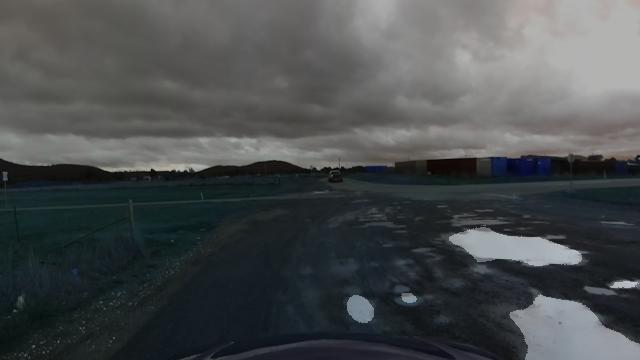

In [8]:
# import the necessary packages
from __future__ import print_function
import numpy as np
import cv2
from IPython.display import Image

img_name = "000000101.png"
path = "/network/tmp1/cosnegau/"
bin_path = "results/"+img_name
img_path = "Dataset/images/on_road/img_"+img_name
# load the image

original_image = cv2.imread(path+img_path)
overlay = cv2.imread(path+bin_path)
overlay = cv2.resize(overlay,(int(original_image.shape[1]),int(original_image.shape[0])))
alpha= 0.3
# apply the overlay
new_im = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha,
    0, original_image)

imageio.imsave(path+"results/overlay_"+img_name, new_im)

Image(filename = path+"results/overlay_"+img_name)

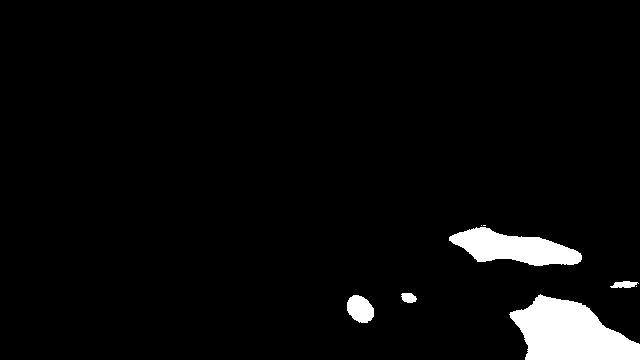

In [6]:
from IPython.display import Image
Image(filename = path+bin_path)